# Demo image registration using SimpleITK

More information can be found at http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import SimpleITK as sitk

In [2]:
fn_img0 = 'img0.png'
img0 = sitk.ReadImage(fn_img0)
print(img0.GetOrigin())
print(img0.GetSpacing())
print(img0.GetDirection())

(0.0, 0.0)
(1.0, 1.0)
(1.0, 0.0, 0.0, 1.0)


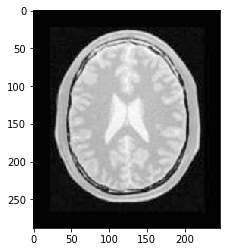

In [7]:
# %% Get numpy array from image

img0_array = sitk.GetArrayFromImage(img0)

plt.imshow(img0_array, cmap='gray')
plt.show()

In [8]:
# %% Read Image for Registration

fixed_image =  sitk.ReadImage('img0.png', sitk.sitkFloat32)
moving_image = sitk.ReadImage('img1.png', sitk.sitkFloat32)

In [14]:
# %% Use the CenteredTransformInitializer to align the centers of 
#   the two volumes and set the center of rotation to the center 
#   of the fixed image.

initial_transform = sitk.CenteredTransformInitializer(
    fixed_image, 
    moving_image, 
    sitk.Euler2DTransform(), 
    sitk.CenteredTransformInitializerFilter.GEOMETRY)

print(initial_transform)

my_initialization = sitk.Euler2DTransform()
my_initialization.SetTranslation((7.2, 8.4))
print(my_initialization)

itk::simple::Transform
 Euler2DTransform (0x7fc1b67d48d0)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 1
   Modified Time: 1924
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 -0 
     0 1 
   Offset: [0, 0]
   Center: [123, 143.5]
   Translation: [0, 0]
   Inverse: 
     1 0 
     0 1 
   Singular: 0
   Angle       = 0

itk::simple::Euler2DTransform
 Euler2DTransform (0x7fc1af4443b0)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 1
   Modified Time: 1927
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 0 
     0 1 
   Offset: [7.2, 8.4]
   Center: [0, 0]
   Translation: [7.2, 8.4]
   Inverse: 
     1 0 
     0 1 
   Singular: 0
   Angle       = 0



In [ ]:
# Resample an image
moving_resampled = sitk.Resample(moving_image, 
                                 fixed_image,
                                 initial_transform,
                                 sitk.sitkLinear,
                                 0.0,
                                 moving_image.GetPixelID()) # output pixel type

1. Replace the initial transform with "my_initialization" in the above code and show the resampled image below.
2. Change "sitk.sitkLinear" to other interpolators and show the results. Discuss the differences.

In [16]:
# %% Start Image Registration

registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
#registration_method.SetMetricAsCorrelation()
registration_method.SetMetricAsMeanSquares()

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=0.1, 
    numberOfIterations=100, 
    convergenceMinimumValue=1e-6, 
    convergenceWindowSize=10)

# The number of iterations involved in computations are defined by 
# the convergence window size

# Estimating scales of transform parameters a step sizes, from the 
# maximum voxel shift in physical space caused by a parameter change. 
registration_method.SetOptimizerScalesFromPhysicalShift()

# Initialize registration
registration_method.SetInitialTransform(initial_transform, inPlace=False)

In [19]:
# %% Monitor the registration process

# Callback invoked when the StartEvent happens, sets up our new data.
def clear_values():
    global metric_values
    
    metric_values = []


# Connect observers so that we can perform plotting 
# during registration.
registration_method.AddCommand(sitk.sitkStartEvent, 
                               clear_values)
    
# Callback invoked when the IterationEvent happens, update our data 
# and display new figure.    
def save_values(registration_method):
    global metric_values
    value = registration_method.GetMetricValue()
    metric_values.append(value)
    print('Iteration {}: metric value {:.4f}'.format(
        len(metric_values), value))
    
    
# Connect observers so that we can perform plotting 
# during registration.
registration_method.AddCommand(sitk.sitkIterationEvent, 
                               lambda: save_values(registration_method))


0

In [20]:
final_transform = registration_method.Execute(fixed_image, 
                                              moving_image)

print('Final metric value: {0}'.format(
    registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(
    registration_method.GetOptimizerStopConditionDescription()))

moving_resampled = sitk.Resample(moving_image,
                                 fixed_image,
                                 final_transform,
                                 sitk.sitkLinear,
                                 0.0,
                                 moving_image.GetPixelID())

# Save image and transformation to local drive
#
#moving_resampled = sitk.Cast(moving_resampled, sitk.sitkUInt8)
#sitk.WriteImage(moving_resampled, 'moving_resampled.png')
#sitk.WriteTransform(final_transform, 'final_transform.txt')

Iteration 1: metric value 4291.9936
Iteration 2: metric value 4291.9936
Iteration 3: metric value 4109.9925
Iteration 4: metric value 4109.9925
Iteration 5: metric value 3945.1845
Iteration 6: metric value 3945.1845
Iteration 7: metric value 3860.7622
Iteration 8: metric value 3860.7622
Iteration 9: metric value 3719.9541
Iteration 10: metric value 3719.9541
Iteration 11: metric value 3599.7315
Iteration 12: metric value 3599.7315
Iteration 13: metric value 3529.1372
Iteration 14: metric value 3529.1372
Iteration 15: metric value 3448.7134
Iteration 16: metric value 3448.7134
Iteration 17: metric value 3370.4280
Iteration 18: metric value 3370.4280
Iteration 19: metric value 3329.1399
Iteration 20: metric value 3329.1399
Iteration 21: metric value 3231.4491
Iteration 22: metric value 3231.4491
Iteration 23: metric value 3190.3910
Iteration 24: metric value 3190.3910
Iteration 25: metric value 3083.6679
Iteration 26: metric value 3083.6679
Iteration 27: metric value 3033.2142
Iteration 

3. Use "matplotlib.pyplot.plot" to plot the metric values over itations.
4. Show the initial difference image and final difference image after registration.
5. Use correlation as image registration metric and repeat steps 3 and 4.